## Practical Exercise 1: An Introduction to Word Embeddings and Word2Vec

Before we start, we would like to highlight that each of the three notebooks will contribute equally to your final grade.

This practical Exercise is presented as an IPython Notebook, with the code written for recent versions of **Python 3**.

Before working with this notebook, you need to execute some of the pre-coded cells (to load libraries/functions/modules etc.). To execute one notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Below is a list with potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

#### Introduction & imports

In this notebook you will familiarize yourselves with constructing and using word-embeddings. As you recall from the lecture, word-embeddings are a type of word representation that allow words with similar meaning to have similar representations. This can be achieved by representing words as real-valued vectors in a predefined vector space. However, before delving into the embedding process, you will need to learn how to use some basic NLP tools like tokenization and regular expressions!
Good Luck and happy coding!

In [1]:
# Importing necessary libraries/modules; requires to be executed once for every session
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle
import re
import nltk

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
#nltk.download('punkt')

from wordcloud import WordCloud

Loading BokehJS ...

In [ ]:
# Here we install nltk. You only have to execute this cell once!
try:
    import nltk
except:
    import sys
    !{sys.executable} -m pip install nltk
    import nltk
    nltk.download()

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janni\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Part 0: Download the TED dataset

For this practical exercise, we need a large amount of text data. We will use the TED database, which are the transcripts of Ted Talks. The next cells will download everything you need, this might take a while as the dataset is 75MB large.

In [32]:
import zipfile
import lxml.etree

In [3]:
# Upload the dataset if it's not already there: this may take a minute..
if not os.path.isfile('ted_en-20160408.zip'):
  from google.colab import files
  # select the file "ted_en-20160408.zip" from your local drive here
  uploaded = files.upload()

In [33]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))

print(type(input_text))

<class 'str'>


To give you a little bit of an idea about the structure of the dataset, you can open the `xml` file inside the zip folder and have a look at it. The dataset consists of metadata or properties of TedTalks, such as speaker information, language, transcripts, tags, date, and much more.

As you can see, the `xml` file has lots of different tags to mark the beginning and end of the particular datapoint. The code cell bellow shows the tags that are inside the `xml` file. As you can already imagine, the tags are used to mark different properties of the data. For this assignment, we are interested in the content/text only, which is the reason for extracting the text from the content tag and from it, create the text data.

In [4]:
# Extract all the tags in the XML
tags = [element.tag for element in doc.iter()]

# Get unique tags using a set
unique_tags = set(tags)

# Print the unique tags
for tag in unique_tags:
    print(tag)

# Delete the variable doc to save space as we have alreay extracted the necessary data we need.
del doc

videourl
date
transcriber
dtime
title
description
content
url
head
encoding
xml
translators
videopath
content-type
transcription
seekvideo
translator
transcribers
pagesize
charnum
speaker
reviewer
talkid
wordnum
keywords
reviewers
file


### Part 1: Preprocessing

Although language oftentimes follows strict rules and structures, text datasets in practice are often noisy. Before we can use our text data, we therefore need to clean it. This process is called *preprocessing*. If we don't do this, the data may be inconsistent and therefore more difficult to analyze and work with. You may ask yourself, what exactly do we need to clean, where exactly would we expect inconsistencies? Take a moment and think about it potential hickups in the raw data. What we need to do, is to preprocess the text and bring it into a clean and consistent format, allowing further analyzing steps.

<h4>Exercise 1.1 (3 Points)</h4>



The following part of the code shows a chunk of text from our ted text dataset. Have a look and try to identify **three** issues you can think of that can create a problem for text analysis, next to the one which is already provided. When giving your answer, we ask you to also mention **why** the issues could be problematic (similar to the example given). Each correct answer (naming + explaining the problem) will give 1 point.

In [5]:
# Have a look at the output of this code, to see some text examples.
i = input_text.find("Hyowon Gweon: See this?")
print(input_text[i:i+300])
print()

i = input_text.find("You will earn")
print(input_text[i:i+45])

Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.
Laura Schulz: Told you. (Laughs)
(Video) HG: See this one? (Ball squeaks) Hey Clara, this one's for you. You can go ahead and play. (Laughter)
LS: I don't even have to talk, right? All rig

You will earn 10% of any gold you distributes


<b>Your Solution goes here:</b>
<br>- Speakers' names: embeddings for names will dominate the embedding space unnecessarily.
<br>- Annotations in brackets dominate the embedding space without adding any context.
<br>- remove commas to reduce embedding space
<br>- changing all letters to lowercase, to reduce the embedding space without losing much context

<h4>Exercise 1.2 (9 Points)</h4>

Next we want to create a preprocessing pipeline to later clean the entire dataset in one go. The pipeline takes `input_text` as input and should provide a cleaned and ready-to-use text data called `cleaned_text`.

Your task is to implement this pipeline with **three** functions that each take care of **one** of the **three** issues you listed in exercise 1.1.

Some hints about the pipeline are given as well as the code for the example from 1.1.

#### Do not execute the Preprocessing pipeline, just scroll down and load data from pickled files 

In [34]:
import string
mytext = """Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.
Laura Schulz: Told you. (Laughs)
(Video) HG: See this one? (Ball squeaks) Hey Clara, this one's for you. You can go ahead and play. (Laughter)
LS: I don't even have to talk, right? All rig

You will earn 10% of any gold you distributes"""

def remove_speaker(text):
  ''' takes the text as an input and removes the name of the speaker as output '''

  input_text = text

  X = []
  for line in input_text.split('\n'):
      #print(line)
      m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
      X.extend(m.groupdict()['postcolon'])
  without_speaker="".join(X)
  return without_speaker


## To Do ##
# implement your 3 functions.
# Make the name of the functions sensible.

def remove_annotations(text):
   
  input_text = text
  without_annotations = re.sub(r'\(.*?\)\ *', '', input_text)

  return without_annotations


def remove_capital_letters(text):
  
  return text.lower()

  
def remove_commas(text):

  input_text = text
  without_commas = input_text.replace(",", "")
  return without_commas



def text_cleaned(input_text):

  ''' takes the raw text as input. Runs the text through cleaning functions.
       outputs a clean an preprocessed text for further analysis. '''

  ## To Do ##
  # include your functions here - you can order the pipeline however you want.
  clean_text = remove_speaker(input_text)
  clean_text = remove_annotations(clean_text)
  clean_text = remove_capital_letters(clean_text)
  clean_text = remove_commas(clean_text)

  return clean_text

input_text_clean = text_cleaned(input_text)

In [35]:
len(input_text_clean)

23660193

<h4>Exercise 1.3 (6 Points)</h4>

To continue with building our embedding, we need to tokenize every single word (so that the model has individual tokens to process). Therefore we first need to split the text into sentences and after that into words.
Try it yourselves or use the NLTK-Tools build for this (https://www.kite.com/python/docs/nltk.word_tokenize + https://www.kite.com/python/docs/nltk.sent_tokenize).
To make it easier, we should also delete every character that is not a letter. Additionally, we could decrease the size of our vocabulary. A way to do this is by converting capital characters to lower case characters (but it also has some drawbacks - more on this in exercise 1.4).<br>

Split your text into sentences and save them in the array `sentences_strings_ted`.
Save one variabale `tokens` with all the tokens in the text and one array named `sentences_ted` that contains an array for every sentence, with all the tokenized words of that sentence.<br><br>
Example:<br>
If the text looks like this: "I love cake. You have to be honest, you love it too!", the variables should look like:<br>
sentences_strings_ted=['I love cake.', 'You have to be honest, you love it too!']<br>
sentences_ted=[['i', 'love', 'cake'], ['you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']]<br>
tokens=['i', 'love', 'cake', 'you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']<br><br>

IMPORTANT: Apply this to `input_text_clean`.<br><br>


 **[Hint:]** use pickle file (.pkl) to dump and load the variables like `sentences_strings_ted`, `tokens`, `sentences_ted` to continue where you left, when you comeback next time. It will save a lot of time/effort.

In [36]:
import pickle
translator = str.maketrans('', '', string.punctuation)
stopwords = nltk.corpus.stopwords.words('english')
sentences_strings_ted = nltk.sent_tokenize(input_text_clean)
tokens = nltk.word_tokenize(input_text_clean.translate(translator))
sentences_ted = []
for i in sentences_strings_ted:
    sentences_ted.append(nltk.word_tokenize(i.translate(translator)))
    
preprocessed = [sentences_strings_ted, sentences_ted, tokens]
with open('sentences_strings_ted.pickle', 'wb') as f:
   pickle.dump(sentences_strings_ted, f)

with open('sentences_ted.pickle', 'wb') as f:
   pickle.dump(sentences_ted, f)

with open('tokens.pickle', 'wb') as f:
   pickle.dump(tokens, f)

#### Load Data

In [37]:
#load serialized preprocessed data
with open('sentences_strings_ted.pickle', 'rb') as f:
  sentences_strings_ted = pickle.load(f)

with open('sentences_ted.pickle', 'rb') as f:
  sentences_ted = pickle.load(f)

with open('tokens.pickle', 'rb') as f:
  tokens = pickle.load(f)

<h4>Exercise 1.4 (1 Point)</h4>

The good side of converting all capital letters is, that we reduce the volume of the vocabulary. Thereby we dont differentiate between the the words "today" and "Today". But there is a caveat. Can you think of any downside to this process?

**Your answer goes here:**

 Not differentiating lowercase and capital letters can equate words that might better be kept apart. Many proper nouns are derived from common nouns and so are distinguished only by case, including companies, government organizations and person names. 

Let's quickly see how large our vocabulary turned out to be!

In [44]:
len(sentences_ted)

236805

### Part 2: Word Frequencies

<h4>Exercise 2.1 (2 Points)</h4>

Your next task will be to store the counts of the top 1,000 most frequent words in a list called `counts_ted_top1000` ! There are multiple ways to do this. You can have a look at the Counter-Function (https://docs.python.org/2/library/collections.html) or the FreqDist-Function (https://www.kite.com/python/docs/nltk.FreqDist). If you don't trust any of these, you can of course build your own function. In the end we want an array with tuples of the structure:

counts_ted_top1000 =  [(WordA,FrequencyA),(WordB,FrequencyB)]

In [45]:
from nltk.probability import FreqDist

fdist = FreqDist()
for token in tokens:
    fdist[token] += 1
fdist

FreqDist({'the': 205931, 'and': 144610, 'to': 124653, 'of': 114595, 'a': 104670, 'that': 84120, 'in': 77069, 'i': 65727, 'is': 63102, 'you': 60877, ...})

In [62]:
counts_ted_top1000 = sorted(fdist.items(), key=lambda x:x[1], reverse=True)
counts_ted_top1000 = counts_ted_top1000[:1000]
len(counts_ted_top1000)

1000

The following code is going to plot a histogram with the counts of the  top-30 words as bars.

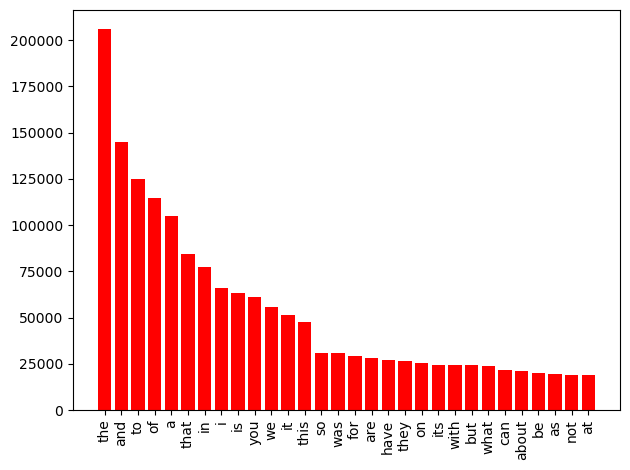

In [63]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000][:mostfreqn]
indices = np.arange(len(counts_ted_top1000[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

Exercise: You can clearly see, that many of the most common words are redundant and not very meaningful. These types of words are called **stopwords**. What problems can stop words create in the NLP and why it is important to remove them?

**Your answer goes here:**

Stop words mostly do not possess important meanings, but still they take up a large portion of the whole texts. Because of that, when doing the frequency analysis in NLP, they might interfere with extracting words that carry more important information or insights from the data. Removing them can make it more clear to see the data that we want to actually check. Also, by doing this, it could reduce the volume from the storage and computational cost, so the speed and efficiency of the model can be enhanced.

<h4>Exercise 2.2 (2 Points)</h4>

Now, write a function that removes the stopwords from the variable `counts_ted_top1000` and save it as `counts_ted_top1000_no_stopword`. Use the code for visualization and spot the differences.

The structure in the end should look like this: counts_ted_top1000_no_stopword = [(WordA,FrequencyA),(WordB,FrequencyB)]

In [82]:
def remove_stopwords(data):
    stop_words = nltk.corpus.stopwords.words('english')
    tmp = []
    for i in data:
        if i[0] not in stop_words:
            tmp.append(i)
    return tmp

counts_ted_top1000_no_stopword = remove_stopwords(counts_ted_top1000)

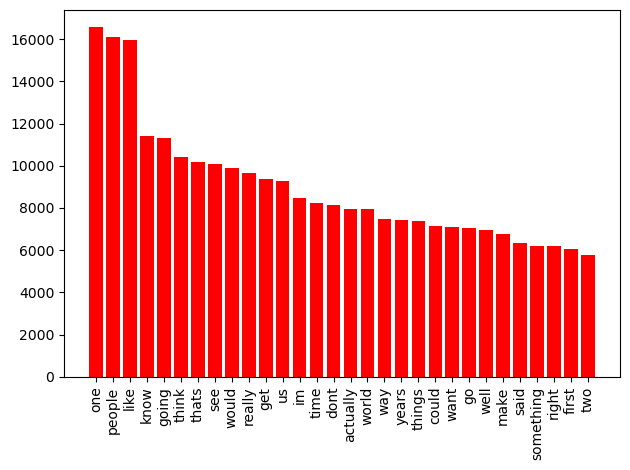

In [69]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
indices = np.arange(len(counts_ted_top1000_no_stopword[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

#### Wordcloud Visualization

The below so-called **wordcloud** shows the most frequent words in a larger font and the less frequent ones in a smaller font size. It's a quick and cool way of visualizing the most frequent words!

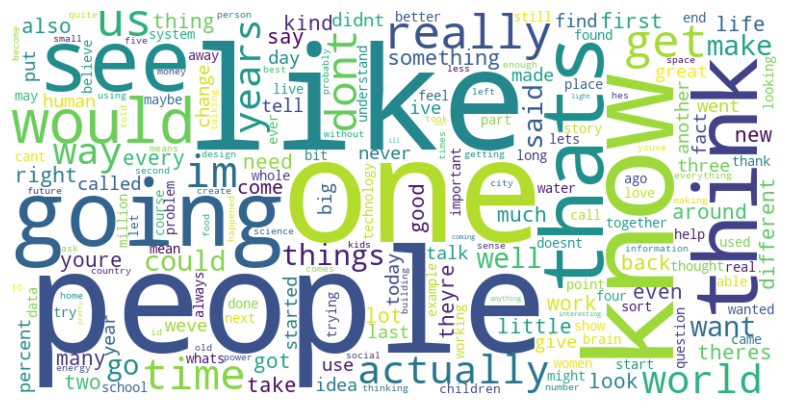

In [87]:
# Create a dictionary that maps words to their frequencies
counts_ted_top1000_no_stopword = {word: count for word, count in counts_ted_top1000_no_stopword}

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
wordcloud.generate_from_frequencies(counts_ted_top1000_no_stopword)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Part 3: Generating the Word Embeddings with Word2Vec

Now it is time to run the embedding model. Gensim has an already implemented model that you can use. Using the provided model is enough for the purposes of our notebook. If you want to dive deeper into the topic - this youtube video https://www.youtube.com/watch?v=kKDYtZfriI8 could be a great guidance for you to get started.

In [71]:
# This takes a moment.. dont worry :D
from gensim.models import Word2Vec

model_ted = Word2Vec(sentences_ted)

### Part 4: Inspection of our learned representations/embeddings (3 Points)


Now that we have a model that captures the word embeddings, we can use it to explore properties of the words in the text.

First, code a line that looks at the embedding of one individual word/token.  What does the representation of "house" look like in the embedding model? You may refer to the following gensim docs for functions, that might help you https://radimrehurek.com/gensim/models/keyedvectors.html). This will give you 1 point.

In [74]:
word_vectors = model_ted.wv
word_vectors["house"]

array([ 1.48660779e-01,  1.78172350e+00, -2.45412564e+00, -1.02769578e+00,
        1.38217306e+00, -1.34315228e+00,  1.15150070e+00, -1.16560137e+00,
        5.63267879e-02,  6.94334954e-02, -7.33144730e-02,  4.62339133e-01,
       -1.19560158e+00,  1.43528044e-01,  2.41000742e-01,  1.05876327e+00,
        1.34356856e+00,  1.21945584e+00, -4.54037458e-01, -1.21795368e+00,
        7.78097391e-01, -3.56103539e-01, -7.12542355e-01, -1.96667683e+00,
        1.13743909e-01, -1.07028171e-01,  1.07612967e+00, -2.65328765e-01,
        8.37196112e-01, -1.39572215e+00, -3.59614491e-01,  7.51722157e-01,
       -7.78749049e-01, -1.61746478e+00,  4.97880310e-01, -3.01405996e-01,
        7.68844426e-01, -7.48219848e-01, -7.11560428e-01, -5.67536950e-01,
        7.36318588e-01, -1.20457046e-01, -8.66131783e-01, -5.06565452e-01,
        4.11731392e-01,  4.85116065e-01, -4.46970105e-01, -4.37643170e-01,
       -4.84614044e-01,  1.12777615e+00,  3.26968282e-01, -2.01375151e+00,
       -7.38853037e-01, -

The next task for you is to output the most similar word to "town"? This will also give you 1 point.

In [75]:
result = word_vectors.most_similar(positive=['town'])
result[0]

('village', 0.872802734375)

Finally, we want to find out how similar the words "town" and "house" are. Again: 1 point for this!

In [78]:
result = word_vectors.most_similar(positive=['town', 'house'])
result[0]

('village', 0.8439068794250488)

<h4>Exercise 4.1 (3 Points)</h4>


Now that we have generated our embeddings, let's test some classical ideas:
implement the following formula. Print out the 10 words, that are most similar to this formula: <br>
$King-Man+Woman=???$
There are two ways of computing similarity in word embeddings:
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar_cosmul.html
You should try out both! In this case one of them is better, but both of them are valid methods for computing similarity in the word-space.

In [80]:
result_cosmul = word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
result_cosine = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
print(f'similarity with cosmul: {result_cosmul[:10]}')
print(f'similarity with cosine: {result_cosine[:10]}')

similarity with cosmul: [('president', 0.9579172134399414), ('al', 0.9407119750976562), ('mayor', 0.9290257692337036), ('luther', 0.9257116913795471), ('queen', 0.9234501123428345), ('obama', 0.9189319610595703), ('former', 0.910672664642334), ('barack', 0.9093398451805115), ('mary', 0.9089668989181519), ('chief', 0.9084121584892273)]
similarity with cosine: [('president', 0.8042113780975342), ('al', 0.7780547738075256), ('luther', 0.7555172443389893), ('mayor', 0.7551513910293579), ('queen', 0.7390405535697937), ('obama', 0.737598717212677), ('john', 0.7270439863204956), ('barack', 0.7258365154266357), ('robert', 0.7232060432434082), ('chief', 0.7218945622444153)]


Exercise 4.2 (2 Points)

The expected outcome (Queen) should be one of the top ten most similar words. But there are also a lot of words, that you would not expect. Think about where how these words might be connected to the formula. Take your time and understand why some of the words (luther, mary, dr, president) might be in this list.

**Your answer goes here:**

It could be because the similarities of each word were separately processed. In word-embeddings, each word, such as a woman or king, has a vector value and the similarities between these words are calculated by the distance of their vector values. A word 'king' as in a leader of a country, has close distance with words like president or mayor, but also it can be a part of a person's name 'martin luther king'. A word might have close distance with a word 'woman' since it is one of typical female names. It also explains why martin or obama are not excluded from the list even though a word 'man' is set to negative since it has a closer connection to a word 'king'

#### t-SNE visualization

We will use the t-SNE algorithm, given below, for visualization. The so-called t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised and non-linear machine learning technique. It is commonly used for visualizing high dimensional data (just like our high dimensional vectors). You do not have to understand the code, its purpose is simply to give you an idea of how the data is arranged in high dimensional space.

<h4>Exercise 4.3 (2 Points)</h4>

To use the t-SNE code below, first put a list of the top 50 words (as **strings**, without **stopwords**) into a variable `words_top_ted`.

In [94]:
words_top_ted, _ = zip(*remove_stopwords(counts_ted_top1000)[:50])

The following code gets the corresponding vectors from the model, assuming it's called `model_ted`:

In [95]:
# This assumes words_top_ted is a list of strings, the top 250 words
words_top_vec_ted = model_ted.wv[words_top_ted]

The next few lines are for the t-SNE visualization.

In [96]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

In [97]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_top_ted))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

That's it. We hope you had fun and learned something in the process :-)